In [5]:
from matplotlib import pyplot
import numpy as np 

import os 

from keras.models import load_model
import h5py
from scipy.stats import pearsonr
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras import optimizers, callbacks, regularizers, initializers
from E2E_conv import *
from E2E_conv import *

batch_size = 14
dropout = 0.5
momentum = 0.9
noise_weight = 0.125
lr = 0.01
decay = 0.0005

# Setting l2_norm regularizer
reg = regularizers.l2(decay)
kernel_init = initializers.he_uniform()

# In[48]:

# Model architecture 
behavdir = "/Users/nicolasfarrugia/Documents/recherche/git/Gold-MSI-LSD77/behav"

X = np.load(os.path.join(behavdir,"X_y_lsd77_static_tangent.npz"))['X']

n_feat = X.shape[1]

model = Sequential()
model.add(E2E_conv(2,32,(2,n_feat),kernel_regularizer=reg,input_shape=(n_feat,n_feat,1),input_dtype='float32',data_format="channels_last"))
print("First layer output shape :"+str(model.output_shape))
model.add(LeakyReLU(alpha=0.33))
#print(model.output_shape)
model.add(E2E_conv(2,32,(2,n_feat),kernel_regularizer=reg,data_format="channels_last"))
print(model.output_shape)
model.add(LeakyReLU(alpha=0.33))
model.add(Convolution2D(64,(1,n_feat),kernel_regularizer=reg,data_format="channels_last"))
model.add(LeakyReLU(alpha=0.33))
model.add(Convolution2D(256,(n_feat,1),kernel_regularizer=reg,data_format="channels_last"))
model.add(LeakyReLU(alpha=0.33))
#print(model.output_shape)
model.add(Dropout(0.5))
model.add(Dense(128,kernel_regularizer=reg,kernel_initializer=kernel_init))
#print(model.output_shape)
model.add(LeakyReLU(alpha=0.33))
#print(model.output_shape)
model.add(Dropout(0.5))
model.add(Dense(30,kernel_regularizer=reg,kernel_initializer=kernel_init))
model.add(LeakyReLU(alpha=0.33))
#print(model.output_shape)
model.add(Dropout(0.5))
model.add(Dense(2,kernel_regularizer=reg,kernel_initializer=kernel_init))
model.add(Flatten())
model.add(LeakyReLU(alpha=0.33))
model.summary()

model.load_weights("BrainCNN-gmsi.h5")

kernel_shape : (2, 64, 1, 32)
data shape : (?, 64, 64, 1)
(1, 64, 1, 32)
(64, 1, 1, 32)
cat1(?, 64, 64, 32)
cat2<dtype: 'float32'>
First layer output shape :(None, 64, 64, 32)
kernel_shape : (2, 64, 32, 32)
data shape : (?, 64, 64, 32)
(1, 64, 32, 32)
(64, 1, 32, 32)
cat1(?, 64, 64, 32)
cat2<dtype: 'float32'>
(None, 64, 64, 32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
e2e_conv_1 (E2E_conv)        (None, 64, 64, 32)        4096      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
e2e_conv_2 (E2E_conv)        (None, 64, 64, 32)        131072    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (

In [6]:
y = np.load(os.path.join(behavdir,"X_y_lsd77_static_tangent.npz"))['y']
labels = np.load(os.path.join(behavdir,"X_y_lsd77_static_tangent.npz"))['labels']


print(labels[3],",",labels[4])

y=y[:,[3,4]]

GoldMSI_Active_sum , GoldMSI_Training_sum


In [12]:
y = np.load(os.path.join(behavdir,"X_y_lsd77_static_tangent.npz"))['y']

In [18]:
ages = y[:,1]

ages.mean(),ages.std()

(25.289509733236841, 3.4501266741991352)

(1, 64, 32, 64)
(1, 64, 32)
(64, 32)


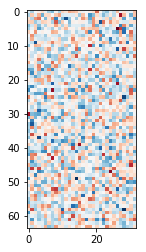

In [3]:
from matplotlib import pyplot as plt 

layer = model.layers[4]
weights = layer.get_weights()[0]
print(weights.shape)
from numpy.linalg import norm
image = norm(weights,axis = 3)
print(image.shape)
image = image.reshape(64,32)
print(image.shape)
plt.imshow(image,cmap='RdBu_r')
plt.show()

In [22]:
import numpy as np
from nilearn import datasets
from nilearn.plotting import find_xyz_cut_coords
from nilearn.image import math_img

basc = datasets.fetch_atlas_basc_multiscale_2015(version='sym')['scale064']

import nibabel as nib 

nib_basc444 = nib.load(basc)
labels_data = nib_basc444.get_data()   

#fetch all possible label values 
all_labels = np.unique(labels_data)
# remove the 0. value which correspond to voxels out of ROIs
all_labels = all_labels[1:]


allcoords=[]
for i,curlabel in enumerate(all_labels):
    img_curlab = math_img(formula="img==%d"%curlabel,img=nib_basc444)
    allcoords.append(find_xyz_cut_coords(img_curlab))

In [7]:
#X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)

def symet(X):
    return 0.5*(X + X.T)

def iden(W):
    return W

In [39]:
from vis import input_modifiers as inpu

binarizer = inpu.InputModifier()

binarizer.post = symet
binarizer.pre = iden

In [40]:
### Here we define the Loss function to estimate ternary activations in a layer 

from vis.losses import Loss

class EstimateTernaryInput(Loss):
    """A loss function that estimates Ternary activations (+1,0,-1) of a set of filters within a particular layer.
    
    One might also use this to generate an input image that is easily interpretable wrt to outputs on the final
    `keras.layers.Dense` layer.
    """
    def __init__(self, img_input):
        """
        Args:
            layer: The keras layer whose filters need to be maximized. This can either be a convolutional layer
                or a dense layer.
            
        """
        #super(ActivationMaximization, self).__init__()
        self.name = "Ternary Activation"
        self.img = img_input
        #self.filter_indices = utils.listify(filter_indices)

    def build_loss(self):
        img = K.cast(self.img,'float32')
        
        img = K.reshape(img,(64,64))

        
        
        loss = 0.
        
        loss += K.sum(K.pow(img-1,2) * K.pow(img+1,2) * K.pow(img,2))
        
        #for row in img:
        #    for val in row:
        #        loss += (val - 1) * (val +1) * val
    

        return loss


In [41]:
from vis.regularizers import LPNorm,TotalVariation
from vis.losses import ActivationMaximization
from vis.utils import utils

from vis.visualization import visualize_activation_with_losses

def visualize_activation_ternary(model, layer_idx, filter_indices=None, wrt_tensor=None,
                         seed_input=None, input_range=(-1, 1),
                         backprop_modifier=None, grad_modifier=None,
                         act_max_weight=1, lp_norm_weight=10, tv_weight=10,alpha=1e-3,
                         **optimizer_params):
    """Generates the model input that maximizes the output of all `filter_indices` in the given `layer_idx`, and
    put it in ternary representation
    Args:
        model: The `keras.models.Model` instance. The model input shape must be: `(samples, channels, image_dims...)`
            if `image_data_format=channels_first` or `(samples, image_dims..., channels)` if
            `image_data_format=channels_last`.
        layer_idx: The layer index within `model.layers` whose filters needs to be visualized.
        filter_indices: filter indices within the layer to be maximized.
            If None, all filters are visualized. (Default value = None)
            For `keras.layers.Dense` layer, `filter_idx` is interpreted as the output index.
            If you are visualizing final `keras.layers.Dense` layer, consider switching 'softmax' activation for
            'linear' using [utils.apply_modifications](vis.utils.utils#apply_modifications) for better results.
        wrt_tensor: Short for, with respect to. The gradients of losses are computed with respect to this tensor.
            When None, this is assumed to be the same as `input_tensor` (Default value: None)
        seed_input: Seeds the optimization with a starting input. Initialized with a random value when set to None.
            (Default value = None)
        input_range: Specifies the input range as a `(min, max)` tuple. This is used to rescale the
            final optimized input to the given range. (Default value=(0, 255))
        backprop_modifier: backprop modifier to use. See [backprop_modifiers](vis.backprop_modifiers.md). If you don't
            specify anything, no backprop modification is applied. (Default value = None)
        grad_modifier: gradient modifier to use. See [grad_modifiers](vis.grad_modifiers.md). If you don't
            specify anything, gradients are unchanged (Default value = None)
        act_max_weight: The weight param for `ActivationMaximization` loss. Not used if 0 or None. (Default value = 1)
        lp_norm_weight: The weight param for `LPNorm` regularization loss. Not used if 0 or None. (Default value = 10)
        tv_weight: The weight param for `TotalVariation` regularization loss. Not used if 0 or None. (Default value = 10)
        alpha : regularization parameter for the ternarization
        optimizer_params: The **kwargs for optimizer [params](vis.optimizer#optimizerminimize). Will default to
            reasonable values when required keys are not found.
    Example:
        If you wanted to visualize the input image that would maximize the output index 22, say on
        final `keras.layers.Dense` layer, then, `filter_indices = [22]`, `layer_idx = dense_layer_idx`.
        If `filter_indices = [22, 23]`, then it should generate an input image that shows features of both classes.
    Returns:
        The model input that maximizes the output of `filter_indices` in the given `layer_idx`.
    """
    if backprop_modifier is not None:
        modifier_fn = get(backprop_modifier)
        model = modifier_fn(model)

    losses = [
        (ActivationMaximization(model.layers[layer_idx], filter_indices), act_max_weight),
        (LPNorm(model.input,1), lp_norm_weight),
        (TotalVariation(model.input), tv_weight),
        (EstimateTernaryInput(model.input), alpha)
    ]

    # Add grad_filter to optimizer_params.
    optimizer_params = utils.add_defaults_to_kwargs({
        'grad_modifier': grad_modifier
    }, **optimizer_params)

    return visualize_activation_with_losses(model.input, losses, wrt_tensor,
                                            seed_input, input_range, **optimizer_params)

In [87]:
heatmaptest = visualize_activation_ternary(model,verbose =0,layer_idx=-1,input_modifiers=[binarizer],
                                   filter_indices=0,
                                           act_max_weight=10, lp_norm_weight=0, tv_weight=0,alpha=100,
                                           input_range = (-1.,1.))[:,:,0]


Dynamic updating of alpha 
--

In [81]:
class DynamicOptimizerCallback(object):
    """Abstract class for defining callbacks for use with [Optimizer.minimize](vis.optimizer#optimizerminimize).
    """
        
    #def _updatealpha(self,opt):
    #    #### TO IMPLEMENT 
    ##    if i < 100 :
    #        alphanew = self.alphastart
    #    else:
    ##        alphanew = self.alphastart + (i-100) * (self.alphaend - self.alphastart) / 100
    #    return alphanew
    
    def callback(self, i, opt, named_losses, overall_loss, grads, wrt_value):
        """This function will be called within [optimizer.minimize](vis.optimizer.md#minimize).
        Args:
            i: The optimizer iteration.
            named_losses: List of `(loss_name, loss_value)` tuples.
            overall_loss: Overall weighted loss.
            grads: The gradient of input image with respect to `wrt_value`.
            wrt_value: The current `wrt_value`.
        """
        print("previous alpha : %f" % K.eval(opt.alpha))
        K.set_value(opt.alpha,K.eval(opt.alpha) * 1.03)
        print("updated alpha : %f" % K.eval(opt.alpha))
        #raise NotImplementedError()

    def on_end(self):
        """Called at the end of optimization process. This function is typically used to cleanup / close any
        opened resources at the end of optimization.
        """
        pass
    
    
from vis.callbacks import OptimizerCallback,pprint
class Print_dyn(OptimizerCallback):
    """Callback to print values during optimization.
    """
    def callback(self, i, opt,named_losses, overall_loss, grads, wrt_value):
        print('Iteration: {}, named_losses: {}, overall loss: {}'
              .format(i + 1, pprint.pformat(named_losses), overall_loss))

In [82]:

from vis.callbacks import Print
from vis.grad_modifiers import get

_PRINT_CALLBACK = Print_dyn()


def _identity(x):
    return x



class OptimizerDynamic(object):

    def __init__(self, input_tensor, losses, input_range=(0, 255) ,alpha=1e-6,wrt_tensor=None, norm_grads=True):
        """Creates an optimizer that minimizes weighted loss function.
        Args:
            input_tensor: An input tensor of shape: `(samples, channels, image_dims...)` if `image_data_format=
                channels_first` or `(samples, image_dims..., channels)` if `image_data_format=channels_last`.
            losses: List of ([Loss](vis.losses#Loss), weight) tuples.
            input_range: Specifies the input range as a `(min, max)` tuple. This is used to rescale the
                final optimized input to the given range. (Default value=(0, 255))
            wrt_tensor: Short for, with respect to. This instructs the optimizer that the aggregate loss from `losses`
                should be minimized with respect to `wrt_tensor`.
                `wrt_tensor` can be any tensor that is part of the model graph. Default value is set to None
                which means that loss will simply be minimized with respect to `input_tensor`.
            norm_grads: True to normalize gradients. Normalization avoids very small or large gradients and ensures
                a smooth gradient gradient descent process. If you want the actual gradient
                (for example, visualizing attention), set this to false.
        """
        self.input_tensor = input_tensor
        self.input_range = input_range
        self.loss_names = []
        self.loss_functions = []
        self.wrt_tensor = self.input_tensor if wrt_tensor is None else wrt_tensor

        self.alpha = K.variable(alpha)
        overall_loss = None
        for curi, (loss, weight) in enumerate(losses):
            # Perf optimization. Don't build loss function with 0 weight.
            if weight != 0:
                ### test on curi 
                if curi==3:
                    loss_fn = self.alpha * loss.build_loss()
                    #print("initial value : " K.eval(self.alpha))
                else:
                    loss_fn = weight * loss.build_loss()
                overall_loss = loss_fn if overall_loss is None else overall_loss + loss_fn
                self.loss_names.append(loss.name)
                self.loss_functions.append(loss_fn)

        # Compute gradient of overall with respect to `wrt` tensor.
        grads = K.gradients(overall_loss, self.wrt_tensor)[0]
        if norm_grads:
            grads = grads / (K.sqrt(K.mean(K.square(grads))) + K.epsilon())

        # The main function to compute various quantities in optimization loop.
        self.compute_fn = K.function([self.input_tensor, K.learning_phase()],
                                     self.loss_functions + [overall_loss, grads, self.wrt_tensor])

    def _rmsprop(self, grads, cache=None, decay_rate=0.95):
        """Uses RMSProp to compute step from gradients.
        Args:
            grads: numpy array of gradients.
            cache: numpy array of same shape as `grads` as RMSProp cache
            decay_rate: How fast to decay cache
        Returns:
            A tuple of
                step: numpy array of the same shape as `grads` giving the step.
                    Note that this does not yet take the learning rate into account.
                cache: Updated RMSProp cache.
        """
        if cache is None:
            cache = np.zeros_like(grads)
        cache = decay_rate * cache + (1 - decay_rate) * grads ** 2
        step = -grads / np.sqrt(cache + K.epsilon())
        return step, cache

    def _get_seed_input(self, seed_input):
        """Creates a random `seed_input` if None. Otherwise:
            - Ensures batch_size dim on provided `seed_input`.
            - Shuffle axis according to expected `image_data_format`.
        """
        desired_shape = (1, ) + K.int_shape(self.input_tensor)[1:]
        if seed_input is None:
            return utils.random_array(desired_shape, mean=np.mean(self.input_range),
                                      std=0.05 * (self.input_range[1] - self.input_range[0]))

        # Add batch dim if needed.
        if len(seed_input.shape) != len(desired_shape):
            seed_input = np.expand_dims(seed_input, 0)

        # Only possible if channel idx is out of place.
        if seed_input.shape != desired_shape:
            seed_input = np.moveaxis(seed_input, -1, 1)
        return seed_input.astype(K.floatx())

    def minimize(self, seed_input=None, max_iter=200,
                 input_modifiers=None, grad_modifier=None,
                 callbacks=None, verbose=True):
        """Performs gradient descent on the input image with respect to defined losses.
        Args:
            seed_input: An N-dim numpy array of shape: `(samples, channels, image_dims...)` if `image_data_format=
                channels_first` or `(samples, image_dims..., channels)` if `image_data_format=channels_last`.
                Seeded with random noise if set to None. (Default value = None)
            max_iter: The maximum number of gradient descent iterations. (Default value = 200)
            input_modifiers: A list of [InputModifier](vis.input_modifiers#inputmodifier) instances specifying
                how to make `pre` and `post` changes to the optimized input during the optimization process.
                `pre` is applied in list order while `post` is applied in reverse order. For example,
                `input_modifiers = [f, g]` means that `pre_input = g(f(inp))` and `post_input = f(g(inp))`
            grad_modifier: gradient modifier to use. See [grad_modifiers](vis.grad_modifiers.md). If you don't
                specify anything, gradients are unchanged. (Default value = None)
            callbacks: A list of [OptimizerCallback](vis.callbacks#optimizercallback) instances to trigger.
            verbose: Logs individual losses at the end of every gradient descent iteration.
                Very useful to estimate loss weight factor(s). (Default value = True)
        Returns:
            The tuple of `(optimized input, grads with respect to wrt, wrt_value)` after gradient descent iterations.
        """
        seed_input = self._get_seed_input(seed_input)
        input_modifiers = input_modifiers or []
        grad_modifier = _identity if grad_modifier is None else get(grad_modifier)

        callbacks = callbacks or []
        if verbose:
            callbacks.append(_PRINT_CALLBACK)

        cache = None
        best_loss = float('inf')
        best_input = None

        grads = None
        wrt_value = None

        for i in range(max_iter):
            # Apply modifiers `pre` step
            for modifier in input_modifiers:
                seed_input = modifier.pre(seed_input)

            # 0 learning phase for 'test'
            computed_values = self.compute_fn([seed_input, 0])
            losses = computed_values[:len(self.loss_names)]
            named_losses = list(zip(self.loss_names, losses))
            overall_loss, grads, wrt_value = computed_values[len(self.loss_names):]

            # TODO: theano grads shape is inconsistent for some reason. Patch for now and investigate later.
            if grads.shape != wrt_value.shape:
                grads = np.reshape(grads, wrt_value.shape)

            # Apply grad modifier.
            grads = grad_modifier(grads)

            # Trigger callbacks
            for c in (callbacks):
                c.callback(i, self, named_losses, overall_loss, grads, wrt_value)

            # Gradient descent update.
            # It only makes sense to do this if wrt_tensor is input_tensor. Otherwise shapes wont match for the update.
            if self.wrt_tensor is self.input_tensor:
                step, cache = self._rmsprop(grads, cache)
                seed_input += step

            # Apply modifiers `post` step
            for modifier in reversed(input_modifiers):
                seed_input = modifier.post(seed_input)

            if overall_loss < best_loss:
                best_loss = overall_loss.copy()
                best_input = seed_input.copy()

        # Trigger on_end
        for c in callbacks:
            c.on_end()

        return utils.deprocess_input(best_input[0], self.input_range), grads, wrt_value

In [83]:
def visualize_activation_with_losses_dynamic(input_tensor, losses, wrt_tensor=None,alpha=1e-6,
                                     seed_input=None, input_range=(0, 255),
                                     **optimizer_params):
    """Generates the `input_tensor` that minimizes the weighted `losses`. This function is intended for advanced
    use cases where a custom loss is desired.
    Args:
        input_tensor: An input tensor of shape: `(samples, channels, image_dims...)` if `image_data_format=
            channels_first` or `(samples, image_dims..., channels)` if `image_data_format=channels_last`.
        wrt_tensor: Short for, with respect to. The gradients of losses are computed with respect to this tensor.
            When None, this is assumed to be the same as `input_tensor` (Default value: None)
        losses: List of ([Loss](vis.losses#Loss), weight) tuples.
        seed_input: Seeds the optimization with a starting image. Initialized with a random value when set to None.
            (Default value = None)
        input_range: Specifies the input range as a `(min, max)` tuple. This is used to rescale the
            final optimized input to the given range. (Default value=(0, 255))
        optimizer_params: The **kwargs for optimizer [params](vis.optimizer#optimizerminimize). Will default to
            reasonable values when required keys are not found.
    Returns:
        The model input that minimizes the weighted `losses`.
    """
    
    ### Configure the Dynamic Callback 
    dyn_cb = DynamicOptimizerCallback()
    
    # Default optimizer kwargs.
    optimizer_params = utils.add_defaults_to_kwargs({
        'seed_input': seed_input,
        'max_iter': 200,
        'callbacks' : [dyn_cb,],
        'verbose': False
    }, **optimizer_params)

    opt = OptimizerDynamic(input_tensor, losses, input_range, alpha,wrt_tensor=wrt_tensor)
    img = opt.minimize(**optimizer_params)[0]

    # If range has integer numbers, cast to 'uint8'
    if isinstance(input_range[0], int) and isinstance(input_range[1], int):
        img = np.clip(img, input_range[0], input_range[1]).astype('uint8')

    if K.image_data_format() == 'channels_first':
        img = np.moveaxis(img, 0, -1)
    return img

In [84]:
from vis.regularizers import LPNorm,TotalVariation
from vis.losses import ActivationMaximization
from vis.utils import utils

from vis.visualization import visualize_activation_with_losses

def visualize_activation_ternary_dynamic(model, layer_idx,alpha=1e-6,filter_indices=None, wrt_tensor=None,
                         seed_input=None, input_range=(-1, 1),
                         backprop_modifier=None, grad_modifier=None,
                         act_max_weight=1, lp_norm_weight=10, tv_weight=10,
                         **optimizer_params):
    """Generates the model input that maximizes the output of all `filter_indices` in the given `layer_idx`, and
    put it in ternary representation
    Args:
        model: The `keras.models.Model` instance. The model input shape must be: `(samples, channels, image_dims...)`
            if `image_data_format=channels_first` or `(samples, image_dims..., channels)` if
            `image_data_format=channels_last`.
        layer_idx: The layer index within `model.layers` whose filters needs to be visualized.
        filter_indices: filter indices within the layer to be maximized.
            If None, all filters are visualized. (Default value = None)
            For `keras.layers.Dense` layer, `filter_idx` is interpreted as the output index.
            If you are visualizing final `keras.layers.Dense` layer, consider switching 'softmax' activation for
            'linear' using [utils.apply_modifications](vis.utils.utils#apply_modifications) for better results.
        wrt_tensor: Short for, with respect to. The gradients of losses are computed with respect to this tensor.
            When None, this is assumed to be the same as `input_tensor` (Default value: None)
        seed_input: Seeds the optimization with a starting input. Initialized with a random value when set to None.
            (Default value = None)
        input_range: Specifies the input range as a `(min, max)` tuple. This is used to rescale the
            final optimized input to the given range. (Default value=(0, 255))
        backprop_modifier: backprop modifier to use. See [backprop_modifiers](vis.backprop_modifiers.md). If you don't
            specify anything, no backprop modification is applied. (Default value = None)
        grad_modifier: gradient modifier to use. See [grad_modifiers](vis.grad_modifiers.md). If you don't
            specify anything, gradients are unchanged (Default value = None)
        act_max_weight: The weight param for `ActivationMaximization` loss. Not used if 0 or None. (Default value = 1)
        lp_norm_weight: The weight param for `LPNorm` regularization loss. Not used if 0 or None. (Default value = 10)
        tv_weight: The weight param for `TotalVariation` regularization loss. Not used if 0 or None. (Default value = 10)
        alpha : regularization parameter for the ternarization
        optimizer_params: The **kwargs for optimizer [params](vis.optimizer#optimizerminimize). Will default to
            reasonable values when required keys are not found.
    Example:
        If you wanted to visualize the input image that would maximize the output index 22, say on
        final `keras.layers.Dense` layer, then, `filter_indices = [22]`, `layer_idx = dense_layer_idx`.
        If `filter_indices = [22, 23]`, then it should generate an input image that shows features of both classes.
    Returns:
        The model input that maximizes the output of `filter_indices` in the given `layer_idx`.
    """
    if backprop_modifier is not None:
        modifier_fn = get(backprop_modifier)
        model = modifier_fn(model)

    losses = [
        (ActivationMaximization(model.layers[layer_idx], filter_indices), act_max_weight),
        (LPNorm(model.input,1), lp_norm_weight),
        (TotalVariation(model.input), tv_weight),
        (EstimateTernaryInput(model.input), alpha)
    ]

    # Add grad_filter to optimizer_params.
    optimizer_params = utils.add_defaults_to_kwargs({
        'grad_modifier': grad_modifier
    }, **optimizer_params)

    return visualize_activation_with_losses_dynamic(model.input, losses, wrt_tensor,alpha,
                                            seed_input, input_range, **optimizer_params)

In [85]:
heatmaptest = visualize_activation_ternary_dynamic(model,verbose = 1,alpha=1e-6,
                                                   layer_idx=-1,input_modifiers=[binarizer],
                                                   filter_indices=0,
                                                   act_max_weight=10, 
                                                   lp_norm_weight=0,
                                                   tv_weight=0,
                                           input_range = (-1.,1.))[:,:,0]


previous alpha : 0.000001
updated alpha : 0.000001
Iteration: 1, named_losses: [('ActivationMax Loss', -0.54736251), ('Ternary Activation', 3.9518214e-05)], overall loss: -0.5473229885101318
previous alpha : 0.000001
updated alpha : 0.000001
Iteration: 2, named_losses: [('ActivationMax Loss', -2.7378466), ('Ternary Activation', 16.875971)], overall loss: 14.138124465942383
previous alpha : 0.000001
updated alpha : 0.000001
Iteration: 3, named_losses: [('ActivationMax Loss', -1.2164038), ('Ternary Activation', 0.011962673)], overall loss: -1.2044411897659302
previous alpha : 0.000001
updated alpha : 0.000001
Iteration: 4, named_losses: [('ActivationMax Loss', -2.9337173), ('Ternary Activation', 4.9312887)], overall loss: 1.9975714683532715
previous alpha : 0.000001
updated alpha : 0.000001
Iteration: 5, named_losses: [('ActivationMax Loss', -2.0378795), ('Ternary Activation', 0.16061783)], overall loss: -1.8772616386413574
previous alpha : 0.000001
updated alpha : 0.000001
Iteration: 6,

previous alpha : 0.000004
updated alpha : 0.000004
Iteration: 49, named_losses: [('ActivationMax Loss', -1.9349109), ('Ternary Activation', 0.22156185)], overall loss: -1.7133491039276123
previous alpha : 0.000004
updated alpha : 0.000004
Iteration: 50, named_losses: [('ActivationMax Loss', -1.9314547), ('Ternary Activation', 0.22694685)], overall loss: -1.704507827758789
previous alpha : 0.000004
updated alpha : 0.000005
Iteration: 51, named_losses: [('ActivationMax Loss', -1.919976), ('Ternary Activation', 0.21567033)], overall loss: -1.704305648803711
previous alpha : 0.000005
updated alpha : 0.000005
Iteration: 52, named_losses: [('ActivationMax Loss', -1.9265921), ('Ternary Activation', 0.22544652)], overall loss: -1.7011456489562988
previous alpha : 0.000005
updated alpha : 0.000005
Iteration: 53, named_losses: [('ActivationMax Loss', -1.9094176), ('Ternary Activation', 0.21641408)], overall loss: -1.693003535270691
previous alpha : 0.000005
updated alpha : 0.000005
Iteration: 54

previous alpha : 0.000017
updated alpha : 0.000018
Iteration: 97, named_losses: [('ActivationMax Loss', -1.4858294), ('Ternary Activation', 0.079312675)], overall loss: -1.406516671180725
previous alpha : 0.000018
updated alpha : 0.000018
Iteration: 98, named_losses: [('ActivationMax Loss', -1.7824228), ('Ternary Activation', 0.37736574)], overall loss: -1.4050570726394653
previous alpha : 0.000018
updated alpha : 0.000019
Iteration: 99, named_losses: [('ActivationMax Loss', -1.4924682), ('Ternary Activation', 0.088776276)], overall loss: -1.4036920070648193
previous alpha : 0.000019
updated alpha : 0.000019
Iteration: 100, named_losses: [('ActivationMax Loss', -1.7648864), ('Ternary Activation', 0.36145529)], overall loss: -1.4034310579299927
previous alpha : 0.000019
updated alpha : 0.000020
Iteration: 101, named_losses: [('ActivationMax Loss', -1.4656911), ('Ternary Activation', 0.10763766)], overall loss: -1.35805344581604
previous alpha : 0.000020
updated alpha : 0.000020
Iteratio

previous alpha : 0.000071
updated alpha : 0.000073
Iteration: 145, named_losses: [('ActivationMax Loss', -1.2120413), ('Ternary Activation', 0.050780442)], overall loss: -1.1612608432769775
previous alpha : 0.000073
updated alpha : 0.000075
Iteration: 146, named_losses: [('ActivationMax Loss', -1.6555314), ('Ternary Activation', 1.0546603)], overall loss: -0.6008710861206055
previous alpha : 0.000075
updated alpha : 0.000077
Iteration: 147, named_losses: [('ActivationMax Loss', -1.2431942), ('Ternary Activation', 0.090940632)], overall loss: -1.1522536277770996
previous alpha : 0.000077
updated alpha : 0.000079
Iteration: 148, named_losses: [('ActivationMax Loss', -1.5391117), ('Ternary Activation', 0.32575691)], overall loss: -1.2133548259735107
previous alpha : 0.000079
updated alpha : 0.000082
Iteration: 149, named_losses: [('ActivationMax Loss', -1.3275092), ('Ternary Activation', 0.13857958)], overall loss: -1.188929557800293
previous alpha : 0.000082
updated alpha : 0.000084
Iter

previous alpha : 0.000275
updated alpha : 0.000283
Iteration: 191, named_losses: [('ActivationMax Loss', -1.2668569), ('Ternary Activation', 0.44528282)], overall loss: -0.8215740919113159
previous alpha : 0.000283
updated alpha : 0.000292
Iteration: 192, named_losses: [('ActivationMax Loss', -1.2553774), ('Ternary Activation', 0.23887108)], overall loss: -1.016506314277649
previous alpha : 0.000292
updated alpha : 0.000300
Iteration: 193, named_losses: [('ActivationMax Loss', -1.3730104), ('Ternary Activation', 0.24865021)], overall loss: -1.124360203742981
previous alpha : 0.000300
updated alpha : 0.000309
Iteration: 194, named_losses: [('ActivationMax Loss', -1.2840117), ('Ternary Activation', 0.47166198)], overall loss: -0.8123497366905212
previous alpha : 0.000309
updated alpha : 0.000319
Iteration: 195, named_losses: [('ActivationMax Loss', -1.2588094), ('Ternary Activation', 0.22905646)], overall loss: -1.0297529697418213
previous alpha : 0.000319
updated alpha : 0.000328
Iterat

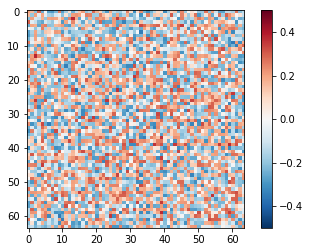

In [145]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.imshow(((heatmaptest)),interpolation='nearest',vmin=-0.5,vmax=0.5,cmap=plt.cm.RdBu_r)
plt.colorbar()


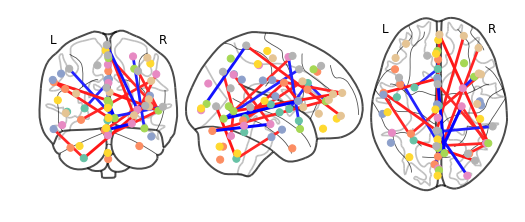

In [138]:
from nilearn.plotting import plot_connectome

plot_connectome((heatmaptest),allcoords,edge_threshold = '99%')



In [45]:
from vis.visualization import visualize_activation


map_engagement_2 = visualize_activation_ternary(model,verbose =0,layer_idx=-1,input_modifiers=[binarizer],
                                   filter_indices=0,
                                           act_max_weight=10, lp_norm_weight=0, tv_weight=0,alpha=1000,
                                           input_range = (-1.,1.))[:,:,0]

map_training_2 = visualize_activation_ternary(model,verbose =0,layer_idx=-1,input_modifiers=[binarizer],
                                   filter_indices=1,
                                           act_max_weight=10, lp_norm_weight=0, tv_weight=0,alpha=1000,
                                           input_range = (-1.,1.))[:,:,0]

In [42]:
map_engagement = visualize_activation_ternary(model,verbose =0,layer_idx=-1,input_modifiers=[binarizer],
                                   filter_indices=0,input_range = (-0.5,0.5))[:,:,0]

map_training = visualize_activation(model,verbose =0,layer_idx=-1,input_modifiers=[binarizer],
                                   filter_indices=1,input_range = (-0.5,0.5))[:,:,0]

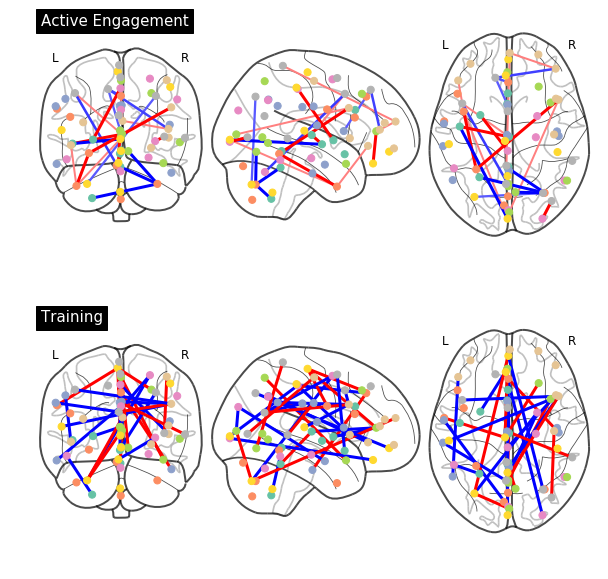

In [47]:
from matplotlib import pyplot as plt 

from nilearn.plotting import plot_connectome
%matplotlib inline 

fig,(ax1,ax2) = plt.subplots(2,figsize=(10,10))

thr  = '99%'

plot_connectome(map_engagement_2,allcoords,edge_threshold = thr,title='Active Engagement',axes=ax1,figure=fig)
plot_connectome(map_training_2,allcoords,edge_threshold = thr,title = "Training",axes=ax2,figure=fig)
plt.show()



In [47]:
heatmap1 = visualize_activation(model,layer_idx=-1, act_max_weight=0, lp_norm_weight=0, tv_weight=0,filter_indices=1,input_range = (-2.,2.))[:,:,0]
heatmap0 = visualize_activation(model,layer_idx=-1, act_max_weight=5, lp_norm_weight=0, tv_weight=0,filter_indices=0,input_range = (-2.,2.))[:,:,0]

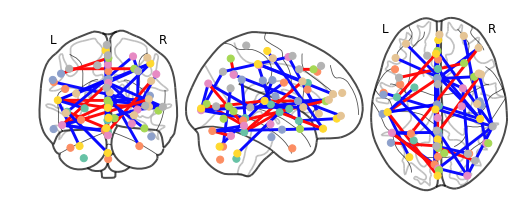

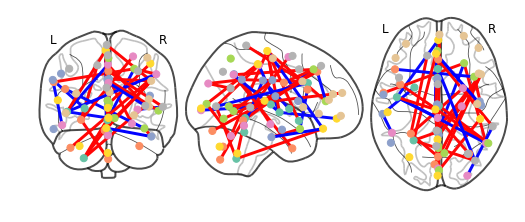

In [48]:
from nilearn.plotting import plot_connectome
%matplotlib inline 
plot_connectome(heatmap1.T+heatmap1,allcoords,edge_threshold = '98%')
plt.show()
plot_connectome(heatmap0.T+heatmap0,allcoords,edge_threshold = '98%')
plt.show()

Tests with SHAP 
--

Keras format :

In [3]:
X = X.reshape(X.shape[0],X.shape[1],X.shape[2],1)


In [4]:
X.shape

(304, 64, 64, 1)

Here we take the Keras model trained above and explain why it makes different predictions for different individuals. SHAP expects model functions to take a 2D numpy array as input, so we define a wrapper function around the original Keras predict function.

In [5]:
def f(X):
    X = X.reshape(X.shape[0],64,64,1)
    return model.predict(X)

In [6]:
import shap
from shap import KernelExplainer, DenseData, visualize, initjs, Instance

# print the JS visualization code to the notebook
initjs()

In [7]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)

In [73]:
featlabs = np.arange(1,64*64+1)
Xdata = DenseData(X_train[:50].reshape(50,64*64),featlabs)
explainer = KernelExplainer(f, Xdata,nsamples=500)

In [ ]:
e = explainer.explain(X_test.reshape(X_test.shape[0],64*64))